In [1]:
import os
import tejapi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# set tej_key and base
tej_key = 'your key'
api_base = 'https://api.tej.com.tw'

os.environ['TEJAPI_KEY'] = tej_key 
os.environ['TEJAPI_BASE'] = api_base

# set date
start = '2022-01-01'
end = '2023-01-01'
os.environ['mdate'] = start + ' ' + end
os.environ['ticker'] = '2330'

In [2]:
!zipline ingest -b tquant

Merging daily equity files:


[2024-01-12 05:34:56.677799] INFO: zipline.data.bundles.core: Ingesting tquant.


In [3]:
from zipline.data import bundles
from zipline.pipeline import Pipeline
from zipline.TQresearch.tej_pipeline import run_pipeline
from zipline.pipeline.data import EquityPricing, TWEquityPricing
from zipline.pipeline.factors import BollingerBands, TrueRange, CustomFactor
from zipline.utils.math_utils import nanmax
from numpy import dstack

start_time = pd.Timestamp(start, tz = 'UTC')
end_time = pd.Timestamp(end,tz = 'UTC')
bundle = bundles.load('tquant')

class AverageTrueRange(CustomFactor):

    inputs = (
        EquityPricing.high,
        EquityPricing.low,
        EquityPricing.close,
    )
    
    window_length = 20

    outputs = ["TR", "SMA_ATR"]
    
    def compute(self, today, assets, out, highs, lows, closes):

        high_to_low = highs[1:] - lows[1:]
        high_to_prev_close = abs(highs[1:] - closes[:-1])
        low_to_prev_close = abs(lows[1:] - closes[:-1])
        tr_current = nanmax(
            dstack(
                (
                    high_to_low,
                    high_to_prev_close,
                    low_to_prev_close,
                )
            ),
            2,
        )

        sma_atr_values = np.mean(tr_current, axis=0)
        
        out.TR = tr_current[-1]
        out.SMA_ATR = sma_atr_values

def make_pipeline():
    
    ATR = AverageTrueRange(inputs = [TWEquityPricing.high,
                                     TWEquityPricing.low,
                                     TWEquityPricing.close])

    perf = BollingerBands(inputs=[EquityPricing.close], window_length=20, k=2)
    upper,middle,lower = perf.upper, perf.middle, perf.lower
    curr_price = EquityPricing.close.latest
    
    return Pipeline(
        columns={
            'SMA_ATR': ATR.SMA_ATR,
            'upper': upper,
            'middle': middle,
            'lower': lower,
            'curr_price': curr_price
        },
    )

pipeline_result = run_pipeline(make_pipeline(), start_time, end_time)
pipeline_result 

,,SMA_ATR,upper,middle,lower,curr_price
2022-01-04 00:00:00+00:00,Equity(0 [2330]),NaN,631.000000,631.000000,631.000000,631.0
2022-01-05 00:00:00+00:00,Equity(0 [2330]),NaN,668.500000,643.500000,618.500000,656.0
2022-01-06 00:00:00+00:00,Equity(0 [2330]),NaN,666.979156,645.666667,624.354177,650.0
2022-01-07 00:00:00+00:00,Equity(0 [2330]),NaN,663.763509,645.250000,626.736491,644.0
2022-01-10 00:00:00+00:00,Equity(0 [2330]),NaN,661.846750,643.000000,624.153250,634.0
...,...,...,...,...,...,...
2022-12-26 00:00:00+00:00,Equity(0 [2330]),10.015883,495.811271,474.605632,453.399993,455.0
2022-12-27 00:00:00+00:00,Equity(0 [2330]),9.415138,496.098595,473.543132,450.987670,456.5
2022-12-28 00:00:00+00:00,Equity(0 [2330]),9.338450,495.276002,472.182492,449.088982,457.0
2022-12-29 00:00:00+00:00,Equity(0 [2330]),8.975450,494.139699,470.372711,446.605723,451.0


In [4]:
from zipline.api import *
from zipline.finance import commission, slippage

def initialize(context):
    set_slippage(slippage.VolumeShareSlippage())
    set_commission(commission.PerShare(cost = 0.001425 + 0.003 / 2))
    set_benchmark(symbol('2330'))
    attach_pipeline(make_pipeline(), 'mystrategy')
    context.last_buy_price = 0
    context.stop_loss = 0

In [5]:
def handle_data(context, data):
    out_dir = pipeline_output('mystrategy')  # 取得每天 pipeline 的布林通道上中下軌 & ATR

    for i in out_dir.index: 
        curr_price = out_dir.loc[i, 'curr_price']
        upper = out_dir.loc[i, 'upper']
        lower = out_dir.loc[i, 'lower']
        atr = out_dir.loc[i, 'SMA_ATR']
        
        cash_position = context.portfolio.cash  # 記錄現金水位
        stock_position = context.portfolio.positions[i].amount  # 記錄股票部位

        loss_stopped, buy, sell = False, False, False
        record(price = curr_price, upper = upper, lower = lower, stop_loss = context.stop_loss, buy = buy, sell = sell, loss_stopped = loss_stopped)

        # 收盤價 > 止損價的狀況：
        if (curr_price > context.stop_loss) or (context.last_buy_price == 0):
            
            # 若收盤價 <= 布林下軌，則買入或加碼
            if (curr_price <= lower) and (cash_position >= curr_price * 1000):
                order(i, 1000)
                buy = True
                record(buy = buy)
                context.stop_loss = curr_price - (0.1 * atr)
                
            # 若收盤價 >= 布林上軌，則出清部位
            elif (curr_price >= upper) and (stock_position >= 1000):
                order_target(i, 0)
                sell = True
                record(sell = sell)
            else:
                pass
        else:
            pass

        # 若收盤價 <= 停損價，則出清部位
        if (curr_price <= context.stop_loss) and (stock_position > 0):
            order_target(i, 0)
            sell = True
            loss_stopped = True
            record(sell = sell, loss_stopped = loss_stopped)
        else:
            pass

In [6]:
def analyze(context, perf):
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    perf.portfolio_value.plot(ax=ax1)
    ax1.set_ylabel("Portfolio value (NTD)")
    ax2 = fig.add_subplot(212)
    ax2.set_ylabel("Stock Price (NTD)")
    perf.price.plot(ax=ax2)
    perf.upper.plot(ax=ax2)
    perf.lower.plot(ax=ax2)
    
    buy_status, sell_status = perf.buy, perf.sell
    buy_status.fillna(False, inplace=True)
    sell_status.fillna(False, inplace=True)
    
    ax2.plot( # 繪製買入訊號
        perf.index[perf.buy],
        perf.loc[perf.buy, 'price'],
        '^',
        markersize=5,
        color='red'
    )
    ax2.plot( # 繪製賣出訊號
        perf.index[perf.sell],
        perf.loc[perf.sell, 'price'],
        'v',
        markersize=5,
        color='green'
    )
    
    plt.legend(loc=0)
    plt.gcf().set_size_inches(18,8)
    plt.show()

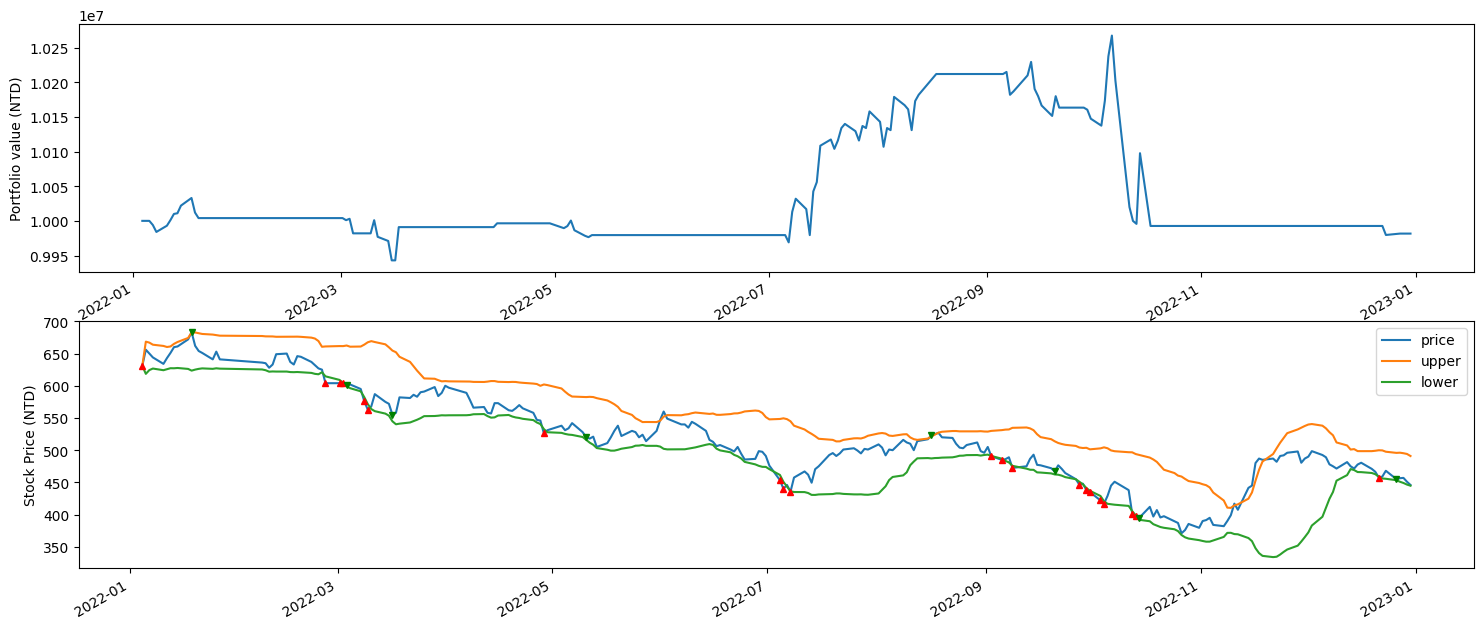

,period_open,period_close,capital_used,portfolio_value,longs_count,shorts_count,long_value,orders,ending_exposure,treasury_return,...,trading_days,period_label,algorithm_period_return,price,upper,lower,stop_loss,buy,sell,loss_stopped
2022-01-03 13:30:00+08:00,2022-01-03 09:01:00+08:00,2022-01-03 13:30:00+08:00,0.000000,1.000000e+07,0,0,0.0,[],0.0,0.0,...,1,2022-01,0.000000e+00,NaN,NaN,NaN,NaN,False,False,NaN
2022-01-04 13:30:00+08:00,2022-01-04 09:01:00+08:00,2022-01-04 13:30:00+08:00,0.000000,1.000000e+07,0,0,0.0,"[{'id': '17ae5cef928c4f478e522b73c84e6b67', 'd...",0.0,0.0,...,2,2022-01,0.000000e+00,631.0,631.000000,631.000000,0.000000,True,False,False
2022-01-05 13:30:00+08:00,2022-01-05 09:01:00+08:00,2022-01-05 13:30:00+08:00,-650002.925012,9.999997e+06,1,0,650000.0,"[{'id': '17ae5cef928c4f478e522b73c84e6b67', 'd...",650000.0,0.0,...,3,2022-01,-2.925012e-07,656.0,668.500000,618.500000,NaN,False,False,False
2022-01-06 13:30:00+08:00,2022-01-06 09:01:00+08:00,2022-01-06 13:30:00+08:00,0.000000,9.993997e+06,1,0,644000.0,[],644000.0,0.0,...,4,2022-01,-6.002925e-04,650.0,666.979156,624.354177,NaN,False,False,False
2022-01-07 13:30:00+08:00,2022-01-07 09:01:00+08:00,2022-01-07 13:30:00+08:00,0.000000,9.983997e+06,1,0,634000.0,[],634000.0,0.0,...,5,2022-01,-1.600293e-03,644.0,663.763509,626.736491,NaN,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26 13:30:00+08:00,2022-12-26 09:01:00+08:00,2022-12-26 13:30:00+08:00,0.000000,9.981130e+06,1,0,456500.0,"[{'id': '4b64125852e746189e73dc288cabaf57', 'd...",456500.0,0.0,...,242,2022-12,-1.886994e-03,455.0,495.811271,453.399993,456.517601,False,True,True
2022-12-27 13:30:00+08:00,2022-12-27 09:01:00+08:00,2022-12-27 13:30:00+08:00,456997.074584,9.981627e+06,0,0,0.0,"[{'id': '4b64125852e746189e73dc288cabaf57', 'd...",0.0,0.0,...,243,2022-12,-1.837286e-03,456.5,496.098595,450.987670,456.517601,False,False,False
2022-12-28 13:30:00+08:00,2022-12-28 09:01:00+08:00,2022-12-28 13:30:00+08:00,0.000000,9.981627e+06,0,0,0.0,[],0.0,0.0,...,244,2022-12,-1.837286e-03,457.0,495.276002,449.088982,456.517601,False,False,False
2022-12-29 13:30:00+08:00,2022-12-29 09:01:00+08:00,2022-12-29 13:30:00+08:00,0.000000,9.981627e+06,0,0,0.0,[],0.0,0.0,...,245,2022-12,-1.837286e-03,451.0,494.139699,446.605723,456.517601,False,False,False


In [7]:
from zipline import run_algorithm

results = run_algorithm(
    start = start_time,
    end = end_time,
    initialize=initialize,
    bundle='tquant',
    analyze=analyze,
    capital_base=1e7,
    handle_data = handle_data
)

results

In [8]:
import pyfolio as pf 
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
benchmark_rets = results['benchmark_return']

<AxesSubplot:title={'center':'Rolling Sharpe ratio (6-month)'}, ylabel='Sharpe ratio'>

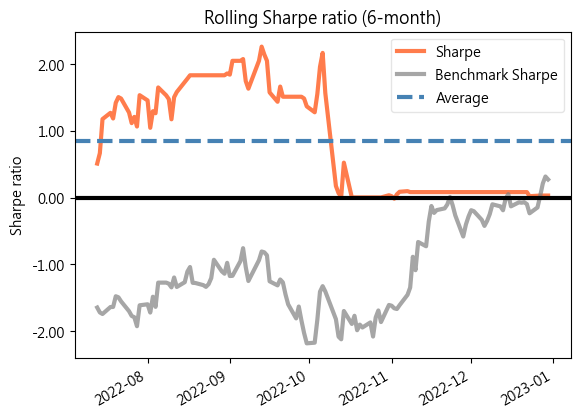

In [9]:
from pyfolio.plotting import plot_rolling_sharpe

plot_rolling_sharpe(returns,
                    factor_returns=benchmark_rets
                       )

In [10]:
from pyfolio.plotting import show_worst_drawdown_periods
show_worst_drawdown_periods(returns, top=5)

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,2.80,2022-10-06,2022-12-23,NaT,NaN
1,0.90,2022-09-13,2022-10-03,2022-10-05,17
2,0.90,2022-01-17,2022-03-15,2022-07-13,116
3,0.50,2022-07-29,2022-08-02,2022-08-05,6
4,0.47,2022-08-05,2022-08-10,2022-08-12,6


<AxesSubplot:ylabel='Cumulative returns'>

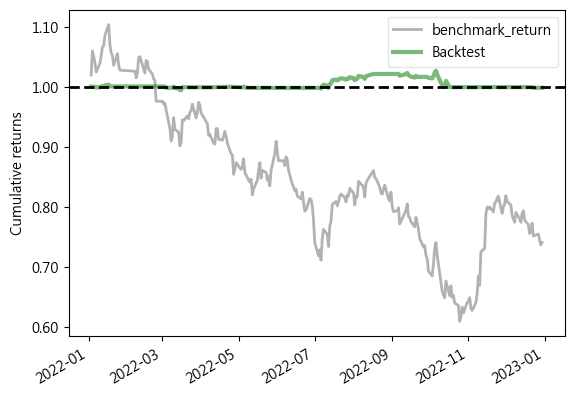

In [11]:
pf.plotting.plot_rolling_returns(returns, factor_returns=benchmark_rets)

<AxesSubplot:title={'center':'Rolling volatility (6-month)'}, ylabel='Volatility'>

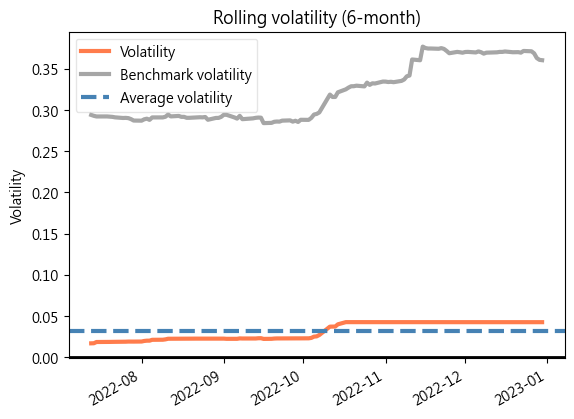

In [12]:
from pyfolio.plotting import plot_rolling_volatility
plot_rolling_volatility(returns,
                        factor_returns=benchmark_rets)

In [13]:
pf.plotting.show_perf_stats(
        returns,
        benchmark_rets,
        positions=positions,
        transactions=transactions)

Start date,2022-01-03
End date,2022-12-30
Total months,11
,Backtest
Annual return,-0.188%
Cumulative returns,-0.184%
Annual volatility,3.14%
Sharpe ratio,-0.04
Calmar ratio,-0.07
Stability,0.07
Max drawdown,-2.803%


,Backtest
Annual return,-0.188%
Cumulative returns,-0.184%
Annual volatility,3.14%
Sharpe ratio,-0.044307
Calmar ratio,-0.067148
Stability,0.069493
Max drawdown,-2.803%
Omega ratio,0.984833
Sortino ratio,-0.056837
Skew,-2.710954
